In [1]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
IMAGE_SHAPE=(224,224)

In [3]:
import pathlib
data_dir=pathlib.Path("/home/sanjana/Desktop/medical_imaging/cervical-cancer")
data_dir

PosixPath('/home/sanjana/Desktop/medical_imaging/cervical-cancer')

In [4]:
image_count=len(list(data_dir.glob('*/*jpg')))
image_count

962

In [5]:
lesions_dict={
    'NILM': list(data_dir.glob('NILM/*')),
    'LSIL': list(data_dir.glob('LSIL/*')),
    'HSIL': list(data_dir.glob('HSIL/*')),
    'SCC': list(data_dir.glob('SCC/*')),
}

In [6]:
lesions_labels={
    'NILM': 0,
    'LSIL': 1,
    'HSIL': 2,
    'SCC': 3,
}

In [7]:
x, y=[],[]
for lesions_name, images in lesions_dict.items():
    for image in images:
        img=cv2.imread(str(image))
        x.append(img)
        y.append(lesions_labels[lesions_name])

In [8]:
x=np.array(x)
y=np.array(y)

In [9]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [10]:
x_train_scaled=x_train/255
x_test_scaled=x_test/255
x_val_scaled=x_val/255
print(len(x_train_scaled))
print(len(x_val_scaled))
print(len(x_test_scaled))

576
193
193


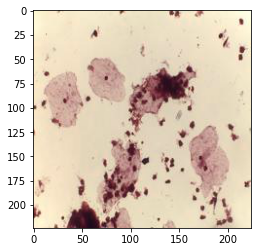

In [11]:
plt.imshow(x[9])

In [105]:
classifier="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
mod=hub.KerasLayer(classifier, input_shape=(224,224,3), trainable=False)

In [106]:
data_aug=keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(224,224,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
])

In [107]:
num_lesions=4
model=tf.keras.Sequential([
    data_aug,
    mod, tf.keras.layers.Dense(num_lesions)
])
model.summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_36 (Sequential)   (None, 224, 224, 3)       0         
_________________________________________________________________
keras_layer_18 (KerasLayer)  (None, 1001)              3540265   
_________________________________________________________________
dense_18 (Dense)             (None, 4)                 4008      
Total params: 3,544,273
Trainable params: 4,008
Non-trainable params: 3,540,265
_________________________________________________________________


In [108]:
import matplotlib.pyplot as plt

model.compile(
    optimizer="adam", 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc'])

history = model.fit(x_train_scaled, y_train, validation_data=(x_val_scaled, y_val), batch_size=64,epochs=10)
print(history.history.keys())


Epoch 1/10
9/9 [==============================] - 14s 1s/step - loss: 1.5403 - acc: 0.5156 - val_loss: 0.9824 - val_acc: 0.7047
Epoch 2/10
9/9 [==============================] - 11s 1s/step - loss: 0.6649 - acc: 0.7656 - val_loss: 0.7021 - val_acc: 0.7668
Epoch 3/10
9/9 [==============================] - 11s 1s/step - loss: 0.4393 - acc: 0.8368 - val_loss: 0.4323 - val_acc: 0.8394
Epoch 4/10
9/9 [==============================] - 11s 1s/step - loss: 0.3246 - acc: 0.8681 - val_loss: 0.4874 - val_acc: 0.8135
Epoch 5/10
9/9 [==============================] - 11s 1s/step - loss: 0.2525 - acc: 0.9062 - val_loss: 0.3628 - val_acc: 0.8549
Epoch 6/10
9/9 [==============================] - 11s 1s/step - loss: 0.2103 - acc: 0.9323 - val_loss: 0.3546 - val_acc: 0.8497
Epoch 7/10
9/9 [==============================] - 11s 1s/step - loss: 0.1917 - acc: 0.9392 - val_loss: 0.3425 - val_acc: 0.8549
Epoch 8/10
9/9 [==============================] - 11s 1s/step - loss: 0.1744 - acc: 0.9531 - val_loss: 0

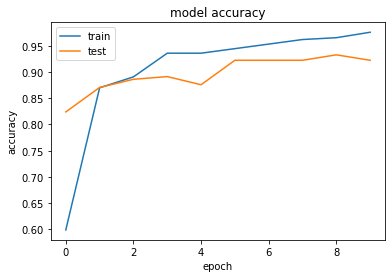

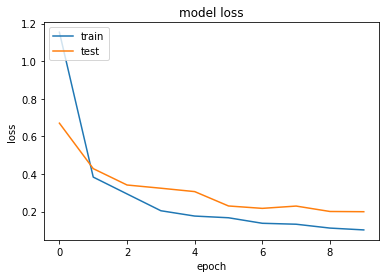

In [77]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [109]:
model.evaluate(x_test_scaled, y_test)

7/7 [==============================] - 2s 328ms/step - loss: 0.2688 - acc: 0.8756


[0.26882073283195496, 0.8756476640701294]

In [35]:
len(x_train_scaled)

721